In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from mongoengine import *
from urllib.parse import urlparse, parse_qsl
connect('mongoengine_documents')
import matplotlib.pyplot as plt
import numpy as np

from mongo_classes import *

In [7]:
print(similarity.objects.count())


0


In [5]:
total_refs = scopus_ref.objects
#climate_refs = scopus_ref.objects.filter(text__icontains="climate change")
#climate_refs_n = climate_refs.count()

In [6]:
print(total_refs.count())

5450866


In [4]:
print(climate_refs_n)

525732


In [5]:
sdocs = scopus_doc.objects
print(sdocs.count())
climate_sdocs = sdocs.filter(TI__icontains="climate change").count()
print(climate_sdocs)

381396
40806


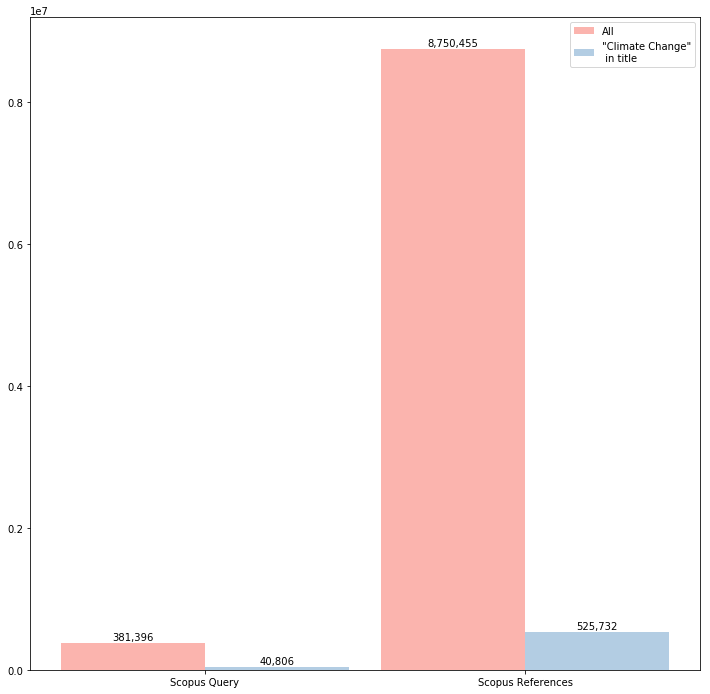

In [38]:
fig_size = [None,None]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

ind = np.arange(2)
ind2 = ind + width
width = 0.45

trefs = [sdocs.count(),total_refs.count()]
crefs = [climate_sdocs,climate_refs_n]

fig,ax = plt.subplots()

p1 = ax.bar(ind,trefs,color='#fbb4ae',width=width)
p2 = ax.bar(ind+width,crefs,color='#b3cde3',width=width)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+10000,
                '%s' % format(int(height),','),
                ha='center', va='bottom')
        
autolabel(p1)
autolabel(p2)

plt.xticks(ind+width/2,('Scopus Query','Scopus References'))
plt.legend((p1[0],p2[0]),('All','"Climate Change"\n in title'))

plt.savefig('../plots/scopus_docs_refs.png',bbox_inches='tight')
plt.show()
